# Dynamic Nested Sampling of Jones scalars observables (noisy angular quantities) with uncertainty inference

**Disclaimer: there is an issue where the evidence is not converging with the dynamic sampler in the release candidate for 1.0. This will be fixed. Doing a non-dynamic nested sampling with more num_live_points does indeed converge with arbitrary accuracy to the true value.**

This is a simple physics model where our data, $y$, is modelled as the principle argument of a unitary complexy vector with white noise added, i.e. the phase of a complex RV, $\phi_\nu = K \tau \nu^{-1} + M \eta \nu + \epsilon$

$L(x) = P(y | x) = \mathcal{N}[y \mid \phi_{\rm obs},\sigma^2 \mathbf{I}]$

where $\phi_{\rm obs} = \arg Y$ and $Y \sim \mathcal{N}(e^{i \phi}, \sigma^2 \mathbf{I}_{\mathbb{C}})$

and we take the priors,

$P(\tau) = \mathcal{C}[\tau \mid 0, 100]$ (Cauchy)


$P(\eta) = \mathcal{U}[\eta \mid -2, 2]$ (Uniform)


$P(\epsilon) = \mathcal{U}[\epsilon \mid -\pi, \pi]$ (Uniform)


$P(\sigma) = \mathcal{H}[\sigma \mid 0.5]$ (Half-Laplace)





## Overview

We'll cover the following topics:

1. How to define a model using `PriorChain`.
2. How to define _a_ likelihood with angular parameters.
3. How to brute-force compute the evidence for comparison.
4. How to compute Bayesian evidence of your model with **dynamic** nested sampling.
5. How to and plot your results.
6. How to iteratively refine your results until you're happy with the precision.

In [1]:
from jaxns.nested_sampler.nested_sampling import NestedSampler
from jaxns.plotting import plot_diagnostics, plot_cornerplot
from jaxns.utils import summary, analytic_log_evidence
from jaxns.prior_transforms import UniformPrior, PriorChain, HalfLaplacePrior, CauchyPrior
from jax import jit
from jax import numpy as jnp, random
import pylab as plt

In [2]:

TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs


INFO[2022-03-03 10:51:05,402]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-03-03 10:51:05,402]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-03-03 10:51:05,403]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-03-03 10:51:05,404]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


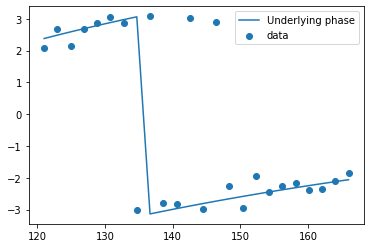

In [3]:
# Generate data
key = random.PRNGKey(42)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [4]:

def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx


def log_likelihood(tec, const, clock, uncert, **kwargs):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)


with PriorChain() as prior_chain:
    CauchyPrior('tec', 0., 100.)
    UniformPrior('const', -jnp.pi, jnp.pi)
    UniformPrior('clock', -2., 2.)
    HalfLaplacePrior('uncert', 0.5)

In [5]:
# The analytic evidence, from brute-force calculation (warning uses > 2GB RAM)
log_Z = analytic_log_evidence(prior_chain, log_likelihood, S=60)

print(f"True log(Z): {log_Z}")

WARNING[2022-03-03 10:51:06,865]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.


True log(Z): -12.056701843339873


In [6]:
# We'll use dynamic nested sampling
ns = NestedSampler(log_likelihood, prior_chain, dynamic=True)

# We'll be interested in also refining the solution later, so we'll also return the state.
# Since return_state invokes a python switch, we need to make it a static argument when jit-compiling.
# For a dynamic goal, we'll to minimise evidence uncertainty, G -> 0.
# For a dynamic termination condition, we'll start with log_Z uncertainty < 0.1
# We'll do a maximum of 5 threads of refinement.
results, state = jit(ns, static_argnames='return_state')(key,
                                                         num_live_points=prior_chain.U_ndims * 100,
                                                         dynamic_kwargs=dict(G=0., f=0.5),
                                                         termination_evidence_uncert=0.1,
                                                         termination_max_num_threads=5,
                                                         return_state=True)


WARNING[2022-03-03 10:51:18,278]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
WARNING[2022-03-03 10:51:18,326]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.
WARNING[2022-03-03 10:51:18,513]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.
WARNING[2022-03-03 10:51:19,328]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.
WARNING[2022-03-03 10:51:19,730]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.


In [7]:
#Let's look at what we have so far.
summary(results)

--------
Termination Conditions:
Reached max num threads
--------
# likelihood evals: 708034
# samples: 7112
# likelihood evals / sample: 99.6
--------
logZ=-11.51 +- 0.11
H=1900.0
ESS=1197
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: -0.1 +- 1.3 | -1.9 / 0.1 / 1.5 | -1.7 | -0.1
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 0.5 +- 1.5 | -1.3 / 0.6 / 2.4 | -0.0 | -2.9
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 105.0 +- 23.0 | 75.0 / 102.0 / 137.0 | 129.0 | 105.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.3 +- 0.045 | 0.248 / 0.293 / 0.359 | 0.345 | 0.274
--------


'--------\nTermination Conditions:\nReached max num threads\n--------\n# likelihood evals: 708034\n# samples: 7112\n# likelihood evals / sample: 99.6\n--------\nlogZ=-11.51 +- 0.11\nH=1900.0\nESS=1197\n--------\nclock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nclock: -0.1 +- 1.3 | -1.9 / 0.1 / 1.5 | -1.7 | -0.1\n--------\nconst: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nconst: 0.5 +- 1.5 | -1.3 / 0.6 / 2.4 | -0.0 | -2.9\n--------\ntec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntec: 105.0 +- 23.0 | 75.0 / 102.0 / 137.0 | 129.0 | 105.0\n--------\nuncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nuncert: 0.3 +- 0.045 | 0.248 / 0.293 / 0.359 | 0.345 | 0.274\n--------'

In [8]:
# We can look at how each iteration reduced evidence uncertainty. It looks like the evidence is going down slowly.
results.thread_stats.evidence_uncert_diff

DeviceArray([0.        , 0.00719942, 0.00562807, 0.00501525, 0.00468585,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ],            dtype=float64)

In [9]:
# Let's refine the solutions
results, state = jit(ns.refine_state, static_argnames='return_state')(state=state,
                                                                      delta_num_live_points=prior_chain.U_ndims * 20,
                                                                      dynamic_kwargs=dict(G=0., f=0.5),
                                                                      termination_evidence_uncert=0.1,
                                                                      termination_max_num_threads=10,
                                                                      return_state=True)


WARNING[2022-03-03 10:51:55,030]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.
WARNING[2022-03-03 10:51:55,445]: Function log_likelihood has **varkw parameter (kwargs), and is being dropped.


In [12]:
#Let's look at what we have so far.
# Looks like the evidence uncertainty got below the threshold of 0.1
summary(results)

--------
Termination Conditions:
Absolute evidence error low enough
--------
# likelihood evals: 795399
# samples: 8333
# likelihood evals / sample: 95.5
--------
logZ=-11.258 +- 0.099
H=1500.0
ESS=1358
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: -0.1 +- 1.3 | -1.8 / 0.2 / 1.6 | 0.2 | -0.1
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 0.6 +- 1.5 | -1.4 / 0.6 / 2.6 | 2.5 | -2.9
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 103.0 +- 23.0 | 74.0 / 99.0 / 137.0 | 95.0 | 105.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.295 +- 0.044 | 0.248 / 0.291 / 0.351 | 0.306 | 0.274
--------


'--------\nTermination Conditions:\nAbsolute evidence error low enough\n--------\n# likelihood evals: 795399\n# samples: 8333\n# likelihood evals / sample: 95.5\n--------\nlogZ=-11.258 +- 0.099\nH=1500.0\nESS=1358\n--------\nclock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nclock: -0.1 +- 1.3 | -1.8 / 0.2 / 1.6 | 0.2 | -0.1\n--------\nconst: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nconst: 0.6 +- 1.5 | -1.4 / 0.6 / 2.6 | 2.5 | -2.9\n--------\ntec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntec: 103.0 +- 23.0 | 74.0 / 99.0 / 137.0 | 95.0 | 105.0\n--------\nuncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nuncert: 0.295 +- 0.044 | 0.248 / 0.291 / 0.351 | 0.306 | 0.274\n--------'

WARNING[2022-03-03 10:52:59,899]: No handles with labels found to put in legend.


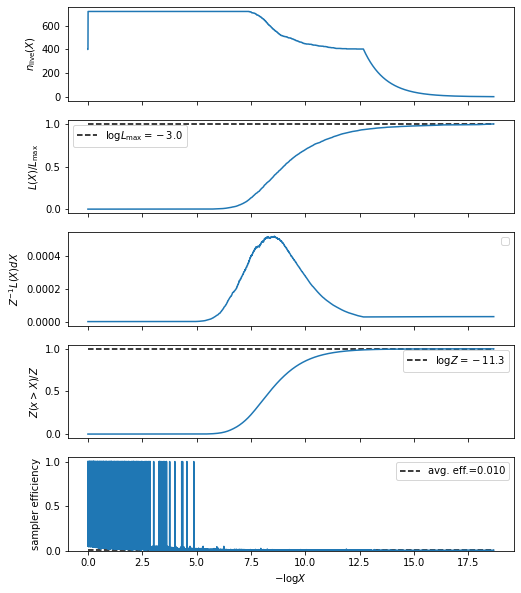

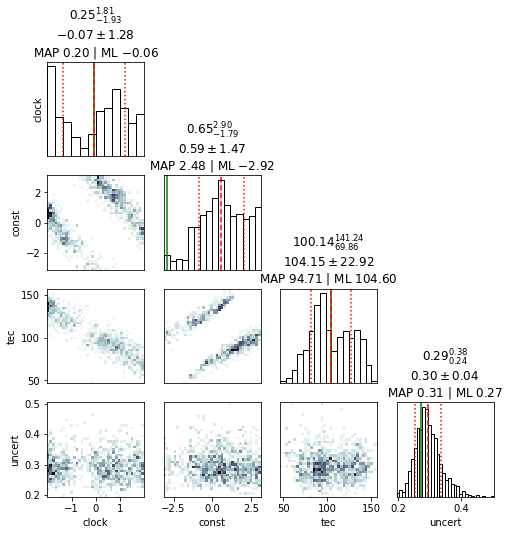

In [13]:
# Finally let's look at the results.
plot_diagnostics(results)
plot_cornerplot(results)

# We can see that the sampler focused more on the initial part of the enclosed prior volume when -logX < 7.5.
# This is evident in the increased n_live points.

In [ ]:
# Finally let's look at the results.
plot_diagnostics(results)
plot_cornerplot(results)

In [ ]:
# Finally let's look at the results.
plot_diagnostics(results)
plot_cornerplot(results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 609154
# samples: 5774
# likelihood evals / sample: 105.5
--------
logZ=-11.84 +- 0.14
H=2400.0
ESS=966
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: -0.1 +- 1.3 | -1.9 / 0.1 / 1.7 | 0.3 | -0.1
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 0.6 +- 1.5 | -1.4 / 0.6 / 2.5 | 2.0 | -2.9
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 104.0 +- 24.0 | 73.0 / 100.0 / 138.0 | 89.0 | 105.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.297 +- 0.045 | 0.244 / 0.293 / 0.355 | 0.332 | 0.274
--------


WARNING[2022-03-03 10:25:04,379]: No handles with labels found to put in legend.


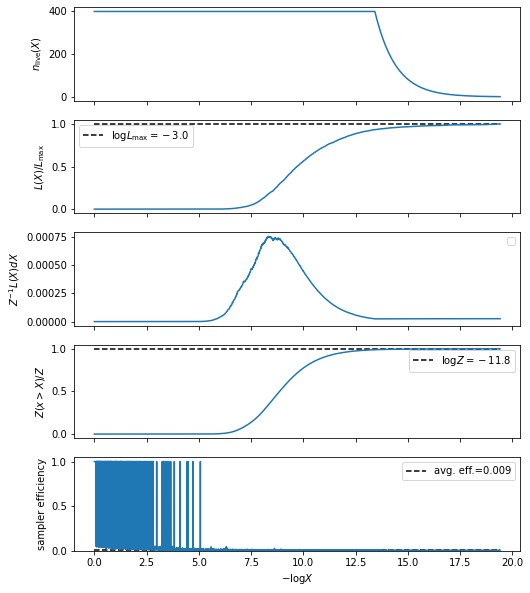

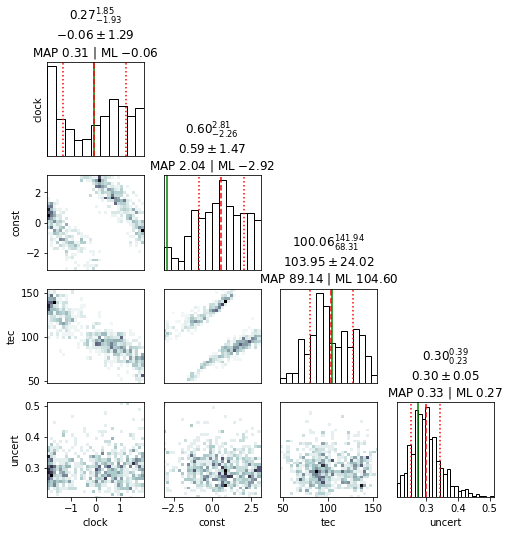

In [9]:
# Plot solutions
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)
